In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import numpy as np
import pandas as pd
from tqdm import tqdm
import tensorflow as tf

import matplotlib.pyplot as plt
from ipywidgets import interact

import tensorflow_addons as tfa
from tensorflow.keras.models import load_model
# from tensorflow_addons.losses import TripletSemiHardLoss, TripletHardLoss

from beeid.utils import sensitivity_map
from plotbee.utils import save_json, read_json

from code.models import simple_cnnv2, ContrastiveLearning
from code.data_utils import load_tf_pair_dataset, load_tf_dataset
from code.viz import show_sensitivity_maps
from code.evaluation import cmc_evaluation, plot_cmc
from code.evaluation import get_interactive_plot_query_gallery

IMAGE_FOLDER = "/mnt/storage/work/jchan/normalized_uncensored_dataset/images/"
DATASET_CSV = "/mnt/storage/work/jchan/body_dataset2/dataset3.csv"

### Prepare dataset

Select the dates for Training, Validation and Testing datasets.

In [2]:
def filter_dataframe(df):
    filtered_df = df[(df.closest_bee > 300)]
    filtered_df = filtered_df[filtered_df.abdomen_size >= 230]
    filtered_df = filtered_df[filtered_df.abdomen_angle >= 200]
    filtered_df = filtered_df[filtered_df.abdomen_angle <= 330]
    filtered_df = filtered_df[filtered_df.V_mean >= 0.30]
    return filtered_df.copy()

df = pd.read_csv(DATASET_CSV)

df = filter_dataframe(df)
df= df[df.tag_id != -1.0]
df["datetime2"] = pd.to_datetime(df["datetime"])
df["days"] = df["datetime2"].dt.strftime("%Y-%m-%d")
df["global_track_id"] = df["video_name"] + "_" + df["track_id"].apply(str)
df["filename"] = IMAGE_FOLDER + df.filename

train_df = df[df.days <= '2019-07-23']
valid_df = df[(df.days > '2019-07-23') & (df.days < '2019-07-25')]
test_df = df[(df.days >= '2019-08-01') & (df.days <= '2019-08-04')]

len(train_df), len(valid_df), len(test_df)

(3777, 1909, 3276)

### Load model

In [16]:
model = load_model("models/contrastive_loss_T0-1.tf")

### Evaluation in function of the amount of Ids

In [17]:
# valid_with_shared_ids_cmc = read_json("results/triplet_loss_eval_by_nids.json")

In [18]:
ITERATIONS=100
NIDS_LIST = [10, 15, 20, 25, 30, 35, 40]

In [19]:
train_ids = train_df.track_tag_id.unique()

valid_with_shared_ids = valid_df[valid_df.track_tag_id.isin(train_ids)]
valid_with_shared_ids_cmc = dict()

for gallery_size in tqdm(NIDS_LIST):
    cmc_curve = cmc_evaluation(model, valid_with_shared_ids, iterations=ITERATIONS, gallery_size=gallery_size)
    valid_with_shared_ids_cmc[gallery_size] = cmc_curve.tolist()

save_json("results/constrastive_lossT0-1_eval_by_nids.json", valid_with_shared_ids_cmc)

100%|██████████| 7/7 [18:57<00:00, 162.49s/it]


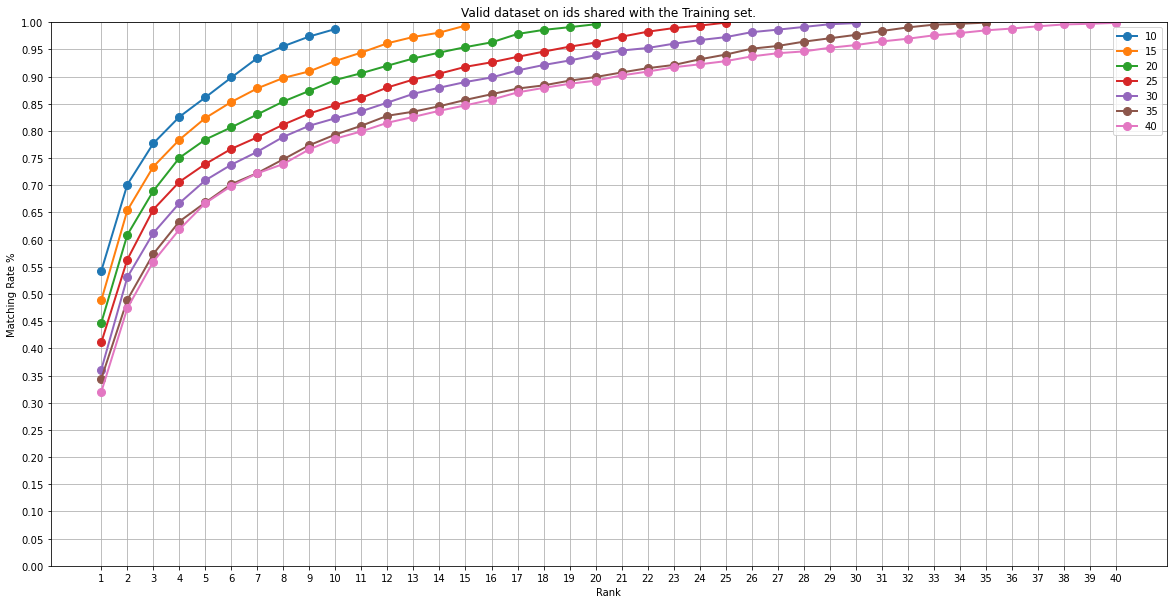

In [20]:
plt.figure(figsize=(20, 10))
for nids, cmc_curve in valid_with_shared_ids_cmc.items():
    x = np.arange(1, int(nids) + 1)
    label = "{}".format(nids)
    plt.plot(x, cmc_curve, 'o-', markersize=8, linewidth=2, label=label)


plt.grid(True)
plt.ylim(0.0, 1.0)
plt.yticks(np.arange(0, 1.05, 0.05));
plt.xticks(np.arange(1, NIDS_LIST[-1] + 1, 1));
plt.xlabel("Rank")
plt.ylabel("Matching Rate %")
plt.legend()
plt.tick_params(axis='y', which='minor', bottom=False)
plt.title("Valid dataset on ids shared with the Training set.");
plt.savefig("imgs/constrastive_lossT0-1_valid_train_nids.png")

In [21]:
test_disjoint_train = test_df[~test_df.track_tag_id.isin(train_ids)]

test_without_shared_ids_cmc = dict()

for gallery_size in tqdm(NIDS_LIST):
    cmc_curve = cmc_evaluation(model, test_disjoint_train, iterations=ITERATIONS, gallery_size=gallery_size)
    test_without_shared_ids_cmc[gallery_size] = cmc_curve.tolist()

save_json("results/constrastive_lossT0-1_test_by_nids.json", test_without_shared_ids_cmc)

100%|██████████| 7/7 [1:00:55<00:00, 522.15s/it]


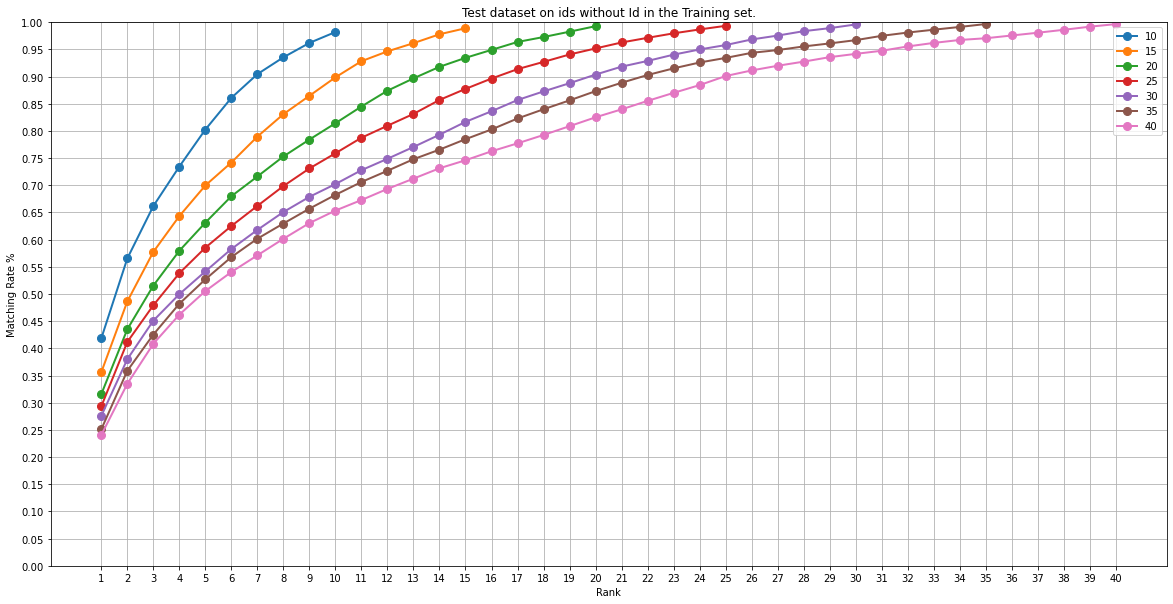

In [22]:
plt.figure(figsize=(20, 10))
for nids, cmc_curve in test_without_shared_ids_cmc.items():
    x = np.arange(1, int(nids) + 1)
    label = "{}".format(nids)
    plt.plot(x, cmc_curve, 'o-', markersize=8, linewidth=2, label=label)


plt.grid(True)
plt.ylim(0.0, 1.0)
plt.yticks(np.arange(0, 1.05, 0.05));
plt.xticks(np.arange(1, NIDS_LIST[-1] + 1, 1));
plt.xlabel("Rank")
plt.ylabel("Matching Rate %")
plt.legend()
plt.tick_params(axis='y', which='minor', bottom=False)
plt.title("Test dataset on ids without Id in the Training set.");
plt.savefig("imgs/constrastive_lossT0-1_test_train_nids.png")